### 03 평균 이동
- 평균 이동(Mean Shift)은 k-평균과 유사하게 중심을 군집의 중심으로 지속적으로 움직임녀서 군집화를 수행, 데이터가 모여 있는 밀도가 가장 높은 곳으로 이동
- 데이터가 모여있어 확률 밀도 함수가 피크인 점을 군집 중심점으로 선정하며 일반적으로 주어진 모델의 확률 밀도 함수를 찾기 위해서 KDE를 이용

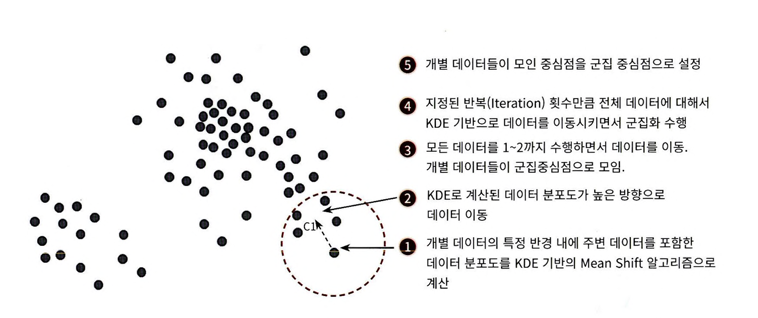

- KDE는 커널 함수를 통해 어떤 변수의 확률 밀도 함수를 추정하는 대표적인 방법, 관측된 데이터 각각에 커널 함수를 적용한 값을 모두 더한 뒤 데이터 건수로 나눠 확률 밀도 함수를 추정

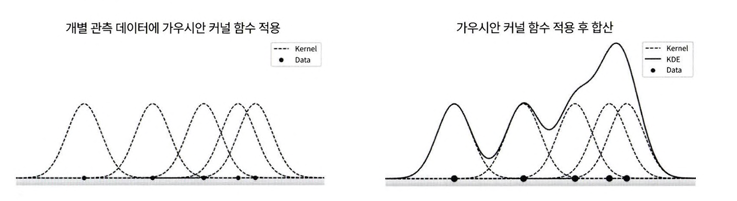

- k는 커널 함수, x는 확률 변숫값, xi는 관측값, h는 대역폭임.
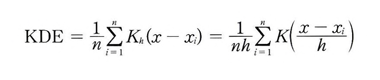

- 대역폭 h는 KDE 형태를 부드러운 형태로 평활화 하는데 적용되며, 이 h를 어떻게 설정하느냐에 따라 확률 밀도 추정 성능을 크게 좌우할 수 있음.

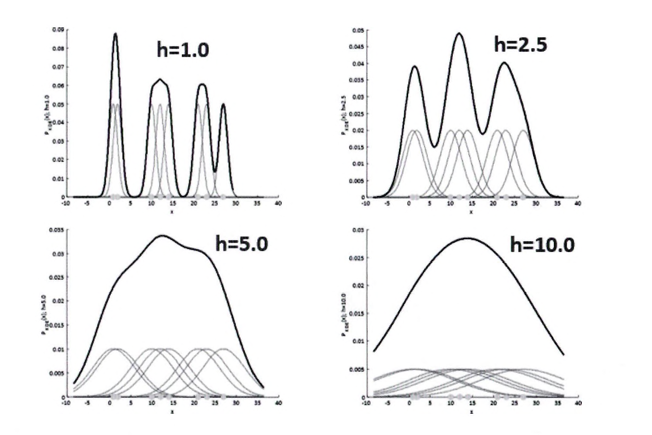

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=0) # 인공 데이터 생성

meanshift = MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3 4 5]


In [2]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X)
print('bandwidth 값:', round(bandwidth, 3))

bandwidth 값: 1.816


In [7]:
import pandas as pd

clusterDF = pd.DataFrame(data=X, columns=['ftr1','ftr2'])
clusterDF['target'] = y

best_bandwidth = estimate_bandwidth(X)

meanshift = MeanShift(bandwidth = best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형 : ', np.unique(cluster_labels))

cluster labels 유형 :  [0 1 2]


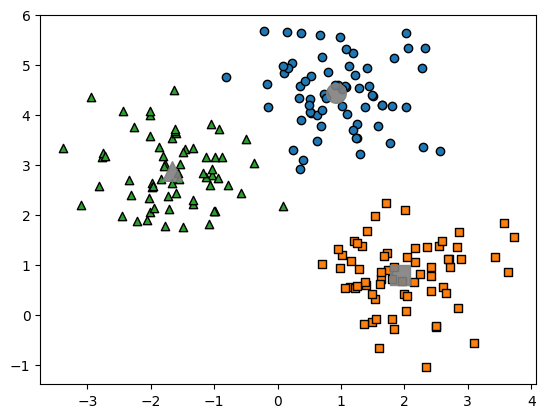

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label'] = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers=['o','s','^','x','*']

for label in unique_labels:
    label_cluster = clusterDF[clusterDF['meanshift_label']==label]
    center_x_y = centers[label]

    # 시각화
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', marker=markers[label])

    # 군집별 중심 표현
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray',alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', marker=''%label)

plt.show()

In [9]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
Name: count, dtype: int64


### 04 GMM(Gaussian Mixture Model)

- GMM 군집화는 군집화를 적용하고자 하는 데이터가 여러 개의 가우시안 분포를 가진 데이터 집합들이 섞여서 생성된 것이라는 가정하에 군집화 수행

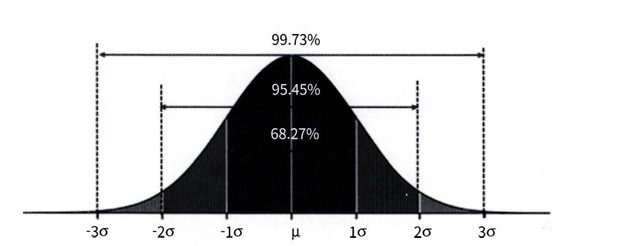

- 모수 추정
  - 개별 정규 분포의 평균과 분산
  - 각 데이터가 어떤 정규 분포에 해당되는지의 확률

### GMM을 이용한 붓꽃 데이터 세트 군집화

In [11]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

# dataframe으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [12]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

# 군집화 결과를 irisDF에 저장
irisDF['gmm_cluster'] = gmm_cluster_labels

# target 값에 따라 gmm_cluster 값이 어떻게 매핑되었는지 확인
iris_result = irisDF.groupby('target')['gmm_cluster'].value_counts()
print(iris_result)


target  gmm_cluster
0       1              50
1       0              45
        2               5
2       2              50
Name: count, dtype: int64


In [13]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels
iris_result = irisDF.groupby('target')['kmeans_cluster'].value_counts()
print(iris_result)

target  kmeans_cluster
0       1                 50
1       0                 47
        2                  3
2       2                 36
        0                 14
Name: count, dtype: int64


### GMM과 K-평균의 비교

- KMeans는 원형의 범위에서 군집화를 수행

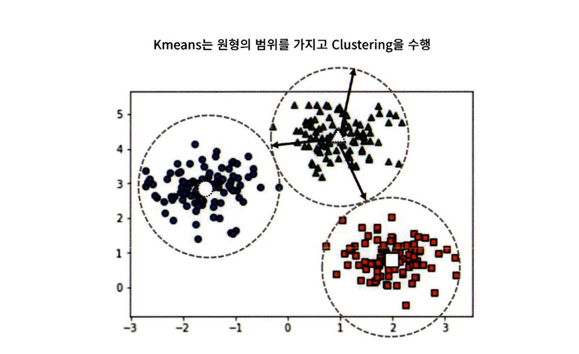

- clusterobj: 사이킷런의 군집 수행 객체, GaussianMixture의 fit()와 predict()로 군집화를 완료한 객체, 만약 군집화 결과 시각화가 아니고 make_blobs()로 생성한 데이터의 시각화일 경우 None 입력
- dataframe: 피처 데이터세트와 label 값을 가진 DataFrame
- label_name: 군집화 결과 시각화일 경우 dataframe 내의 군집화 label 칼럼명, make_blobs() 결과 시각화일 경우는 dataframe 내의 target 칼럼명
- iscenter: 사이킷런 cluster 객체가 군집 중심 좌표를 제공하면 True, 그렇지 않으면, False


In [15]:
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_

    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)

        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)

        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'

    plt.legend(loc=legend_loc)
    plt.show()

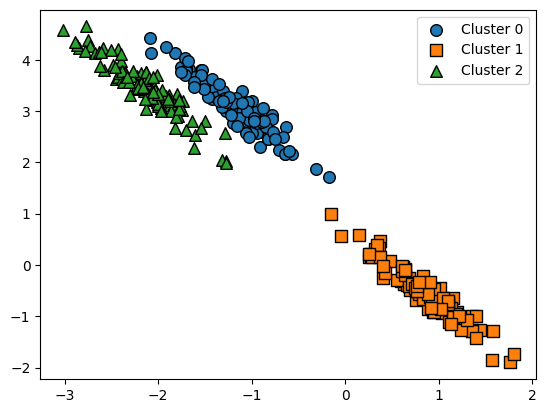

In [16]:
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

# 길게 늘어난 타언형의 데이터 세트를 생성하기 위해 변환
transformation = [[0.60834549, -0.63667341],[-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)

clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1','ftr2'])
clusterDF['target'] = y

# 생성된 데이터 세트를 target별로 다른 마커로 표시해 시각화
visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

<ipython-input-15-f4c266540d94>:24: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\


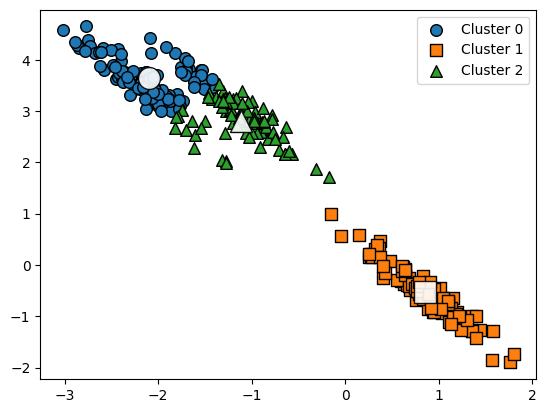

In [17]:
# 3개의 군집 기반 Kmeans를 X_aniso 데이터 세트에 적용
kmeans = KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label', iscenter=True)

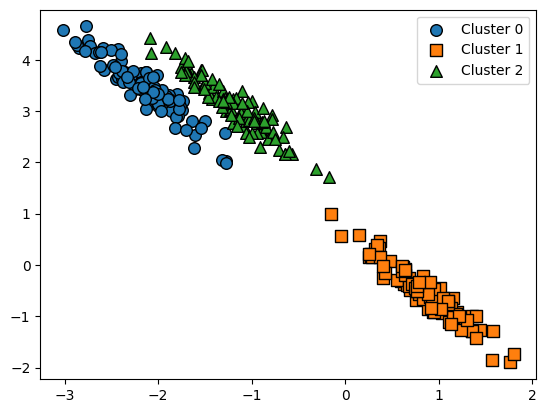

In [18]:
# 3개의 n_components 기반 GMM을 X_aniso 데이터 세트에 적용
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label'] = gmm_label

# GaussianMixture는 cluster_centers_ 속성이 없으므로 iscenter를 False로 설정.
visualize_cluster_plot(gmm, clusterDF, 'gmm_label', iscenter=False)

In [20]:
print('### KMeans Clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('### GMM Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMeans Clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: count, dtype: int64
### GMM Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: count, dtype: int64


- gmm의 경우는 kmeans보다 유연하게 다양한 데이터 세트에 잘 적용될 수 있으나 군집화를 위한 수행 시간이 오래 걸린다는 단점이 존재.